# Data Validation & Quick Model Test

**Tujuan notebook ini:**
1. Validasi loading data dari semua sumber
2. Cek konsistensi data multimodal (images + landmarks)
3. Analisis distribusi kelas emosi
4. Quick test model compilation dan training
5. Estimasi waktu training
6. Identifikasi potential issues sebelum training penuh

**⚠️ JALANKAN NOTEBOOK INI DULU SEBELUM TRAINING PRODUCTION!**

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import pickle

# Setup TensorFlow for AMD GPU (DirectML)
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

# Try to setup DirectML for AMD GPU
try:
    # For AMD GPUs on Windows, try DirectML
    from tensorflow.python.client import device_lib
    
    # List available devices
    devices = device_lib.list_local_devices()
    gpu_devices = [d for d in devices if d.device_type == 'GPU']
    
    if gpu_devices:
        print(f"\n🎮 Found {len(gpu_devices)} GPU(s):")
        for gpu in gpu_devices:
            print(f"   - {gpu.name}: {gpu.physical_device_desc}")
        
        # Configure GPU memory growth to prevent OOM
        gpus = tf.config.experimental.list_physical_devices('GPU')
        if gpus:
            try:
                for gpu in gpus:
                    tf.config.experimental.set_memory_growth(gpu, True)
                print("✅ GPU memory growth enabled")
            except RuntimeError as e:
                print(f"⚠️ GPU setup warning: {e}")
        
        # Test GPU availability
        print(f"\n🔍 GPU Test:")
        print(f"   - GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")
        print(f"   - Built with GPU support: {tf.test.is_built_with_gpu_support()}")
        
        # Set default device for GPU operations
        tf.config.set_soft_device_placement(True)
        print("✅ GPU setup completed successfully!")
        
    else:
        print("⚠️ No GPU detected. Using CPU mode.")
        print("💡 For AMD GPU support, install: pip install tensorflow-directml")
        
except Exception as e:
    print(f"⚠️ GPU setup failed: {e}")
    print("💡 Falling back to CPU mode")
    print("💡 For AMD RX 6600 LE support, install: pip install tensorflow-directml")

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Input, concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

# Set style
plt.style.use('default')
sns.set_palette('husl')

print("\n✅ Libraries imported successfully!")

TensorFlow version: 2.10.0

🎮 Found 2 GPU(s):
   - /device:GPU:0: device: 0, name: DML, pci bus id: <undefined>
   - /device:GPU:1: device: 1, name: DML, pci bus id: <undefined>
✅ GPU memory growth enabled

🔍 GPU Test:
   - GPU Available: True
   - Built with GPU support: False
✅ GPU setup completed successfully!

✅ Libraries imported successfully!


## 1. 🔍 Data Loading Validation

Pertama kita validasi apakah semua data bisa di-load dengan benar dan path-nya konsisten.

In [2]:
# Define base path - SESUAIKAN DENGAN PATH ANDA
BASE_PATH = 'D:/research/2025_iris_taufik/MultimodalEmoLearn-CNN-LSTM/data/'

print("=== DATA LOADING VALIDATION ===")
print(f"Base path: {BASE_PATH}")

# Check if directories exist
image_path = os.path.join(BASE_PATH, 'images')
landmark_path = os.path.join(BASE_PATH, 'landmarks')

print(f"Image path exists: {os.path.exists(image_path)}")
print(f"Landmark path exists: {os.path.exists(landmark_path)}")

if os.path.exists(image_path):
    print(f"Files in image path: {os.listdir(image_path)}")
if os.path.exists(landmark_path):
    print(f"Files in landmark path: {os.listdir(landmark_path)}")

=== DATA LOADING VALIDATION ===
Base path: D:/research/2025_iris_taufik/MultimodalEmoLearn-CNN-LSTM/data/
Image path exists: True
Landmark path exists: True
Files in image path: ['test_images', 'test_image_paths.csv', 'train_images', 'train_image_paths.csv', 'val_images', 'val_image_paths.csv', 'X_test_images.npy', 'X_train_images.npy', 'X_val_images.npy', 'y_test_images.npy', 'y_train_images.npy', 'y_val_images.npy']
Files in landmark path: ['test_metadata.csv', 'train_metadata.csv', 'val_metadata.csv', 'X_test_landmarks.npy', 'X_train_landmarks.npy', 'X_val_landmarks.npy', 'y_test.npy', 'y_train.npy', 'y_val.npy']


In [4]:
# Try loading all data files
data_files = {
    'X_train_images': os.path.join(BASE_PATH, 'images/X_train_images.npy'),
    'X_val_images': os.path.join(BASE_PATH, 'images/X_val_images.npy'),
    'X_test_images': os.path.join(BASE_PATH, 'images/X_test_images.npy'),
    'y_train_images': os.path.join(BASE_PATH, 'images/y_train_images.npy'),
    'y_val_images': os.path.join(BASE_PATH, 'images/y_val_images.npy'),
    'y_test_images': os.path.join(BASE_PATH, 'images/y_test_images.npy'),
    'X_train_landmarks': os.path.join(BASE_PATH, 'landmarks/X_train_landmarks.npy'),
    'X_val_landmarks': os.path.join(BASE_PATH, 'landmarks/X_val_landmarks.npy'),
    'X_test_landmarks': os.path.join(BASE_PATH, 'landmarks/X_test_landmarks.npy')
}

loaded_data = {}
loading_status = {}

for name, path in data_files.items():
    try:
        loaded_data[name] = np.load(path)
        loading_status[name] = '✅ Success'
        print(f"✅ {name}: {loaded_data[name].shape}")
    except Exception as e:
        loading_status[name] = f'❌ Error: {str(e)}'
        print(f"❌ {name}: {str(e)}")

print("\n=== LOADING SUMMARY ===")
success_count = sum(1 for status in loading_status.values() if '✅' in status)
print(f"Successfully loaded: {success_count}/{len(data_files)} files")

if success_count < len(data_files):
    print("\n⚠️ BEBERAPA FILE TIDAK BISA DI-LOAD! Periksa path atau jalankan preprocessing dulu.")
else:
    print("\n🎉 SEMUA FILE BERHASIL DI-LOAD!")

✅ X_train_images: (3123, 224, 224, 3)
✅ X_val_images: (390, 224, 224, 3)
✅ X_test_images: (391, 224, 224, 3)
✅ y_train_images: (3123,)
✅ y_val_images: (390,)
✅ y_test_images: (391,)
✅ X_train_landmarks: (3123, 136)
✅ X_val_landmarks: (390, 136)
✅ X_test_landmarks: (391, 136)

=== LOADING SUMMARY ===
Successfully loaded: 9/9 files

🎉 SEMUA FILE BERHASIL DI-LOAD!


## 2. 📊 Data Consistency Check

Memastikan jumlah samples konsisten antara images, landmarks, dan labels.

In [5]:
if success_count == len(data_files):
    print("=== DATA CONSISTENCY CHECK ===")
    
    # Extract data untuk kemudahan
    X_train_images = loaded_data['X_train_images']
    X_val_images = loaded_data['X_val_images']
    X_test_images = loaded_data['X_test_images']
    
    X_train_landmarks = loaded_data['X_train_landmarks']
    X_val_landmarks = loaded_data['X_val_landmarks']
    X_test_landmarks = loaded_data['X_test_landmarks']
    
    y_train = loaded_data['y_train_images']
    y_val = loaded_data['y_val_images']
    y_test = loaded_data['y_test_images']
    
    # Check shapes
    print("📏 SHAPES:")
    print(f"Images - Train: {X_train_images.shape}, Val: {X_val_images.shape}, Test: {X_test_images.shape}")
    print(f"Landmarks - Train: {X_train_landmarks.shape}, Val: {X_val_landmarks.shape}, Test: {X_test_landmarks.shape}")
    print(f"Labels - Train: {y_train.shape}, Val: {y_val.shape}, Test: {y_test.shape}")
    
    # Check consistency
    consistency_checks = [
        ("Training samples", X_train_images.shape[0] == X_train_landmarks.shape[0] == y_train.shape[0]),
        ("Validation samples", X_val_images.shape[0] == X_val_landmarks.shape[0] == y_val.shape[0]),
        ("Test samples", X_test_images.shape[0] == X_test_landmarks.shape[0] == y_test.shape[0])
    ]
    
    print("\n🔍 CONSISTENCY CHECKS:")
    all_consistent = True
    for check_name, is_consistent in consistency_checks:
        status = "✅" if is_consistent else "❌"
        print(f"{status} {check_name}: {is_consistent}")
        if not is_consistent:
            all_consistent = False
    
    if all_consistent:
        print("\n🎉 ALL DATA IS CONSISTENT!")
    else:
        print("\n⚠️ DATA INCONSISTENCY DETECTED! Fix sebelum training.")
        
    # Data types
    print("\n📋 DATA TYPES:")
    print(f"Images dtype: {X_train_images.dtype}")
    print(f"Landmarks dtype: {X_train_landmarks.dtype}")
    print(f"Labels dtype: {y_train.dtype}")
    print(f"Labels type: {type(y_train[0])}")
    
    # Value ranges
    print("\n📈 VALUE RANGES:")
    print(f"Images: min={X_train_images.min():.3f}, max={X_train_images.max():.3f}")
    print(f"Landmarks: min={X_train_landmarks.min():.3f}, max={X_train_landmarks.max():.3f}")
    print(f"Sample labels: {y_train[:5]}")
    
else:
    print("⚠️ Skipping consistency check karena ada file yang tidak bisa di-load.")

=== DATA CONSISTENCY CHECK ===
📏 SHAPES:
Images - Train: (3123, 224, 224, 3), Val: (390, 224, 224, 3), Test: (391, 224, 224, 3)
Landmarks - Train: (3123, 136), Val: (390, 136), Test: (391, 136)
Labels - Train: (3123,), Val: (390,), Test: (391,)

🔍 CONSISTENCY CHECKS:
✅ Training samples: True
✅ Validation samples: True
✅ Test samples: True

🎉 ALL DATA IS CONSISTENT!

📋 DATA TYPES:
Images dtype: float64
Landmarks dtype: float64
Labels dtype: <U9
Labels type: <class 'numpy.str_'>

📈 VALUE RANGES:
Images: min=0.000, max=1.000
Landmarks: min=-14.912, max=653.725
Sample labels: ['neutral' 'neutral' 'neutral' 'neutral' 'neutral']


## 3. 🎭 Class Distribution Analysis

Analisis distribusi kelas emosi untuk memastikan data balanced dan tidak ada missing classes.

=== CLASS DISTRIBUTION ANALYSIS ===
🏷️ Unique labels: ['angry' 'disgusted' 'happy' 'neutral' 'sad' 'surprised']
📊 Number of classes: 6
🔢 Label mapping: {'angry': 0, 'disgusted': 1, 'happy': 2, 'neutral': 3, 'sad': 4, 'surprised': 5}


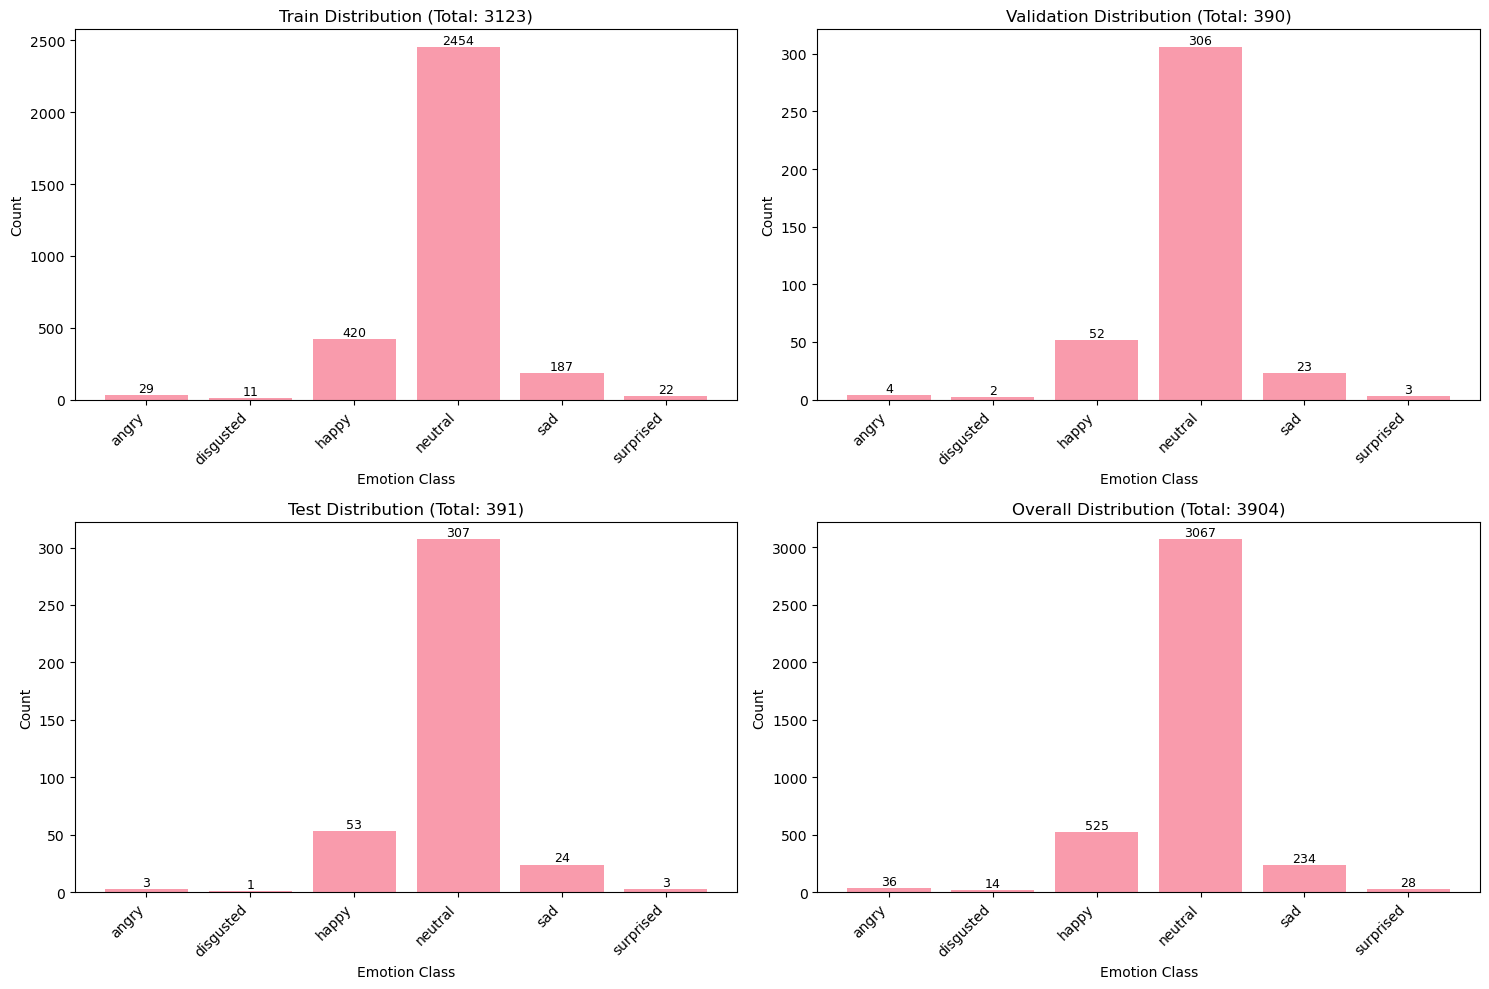


⚖️ CLASS BALANCE ANALYSIS:
Min class count: 11
Max class count: 2454
Imbalance ratio: 223.09
⚠️ SIGNIFICANT CLASS IMBALANCE! Consider using class weights atau resampling.


In [6]:
if success_count == len(data_files):
    print("=== CLASS DISTRIBUTION ANALYSIS ===")
    
    # Get unique labels
    all_labels = np.concatenate([y_train, y_val, y_test])
    unique_labels = np.unique(all_labels)
    
    print(f"🏷️ Unique labels: {unique_labels}")
    print(f"📊 Number of classes: {len(unique_labels)}")
    
    # Create label mapping
    label_map = {label: i for i, label in enumerate(unique_labels)}
    reverse_label_map = {i: label for label, i in label_map.items()}
    
    print(f"🔢 Label mapping: {label_map}")
    
    # Distribution per split
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    splits = [('Train', y_train), ('Validation', y_val), ('Test', y_test), ('Overall', all_labels)]
    
    for i, (split_name, labels) in enumerate(splits):
        ax = axes[i//2, i%2]
        unique, counts = np.unique(labels, return_counts=True)
        
        bars = ax.bar(range(len(unique)), counts, alpha=0.7)
        ax.set_title(f'{split_name} Distribution (Total: {len(labels)})')
        ax.set_xlabel('Emotion Class')
        ax.set_ylabel('Count')
        ax.set_xticks(range(len(unique)))
        ax.set_xticklabels(unique, rotation=45, ha='right')
        
        # Add count labels on bars
        for bar, count in zip(bars, counts):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                   str(count), ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Check for class imbalance
    print("\n⚖️ CLASS BALANCE ANALYSIS:")
    train_unique, train_counts = np.unique(y_train, return_counts=True)
    min_count = train_counts.min()
    max_count = train_counts.max()
    imbalance_ratio = max_count / min_count
    
    print(f"Min class count: {min_count}")
    print(f"Max class count: {max_count}")
    print(f"Imbalance ratio: {imbalance_ratio:.2f}")
    
    if imbalance_ratio > 3:
        print("⚠️ SIGNIFICANT CLASS IMBALANCE! Consider using class weights atau resampling.")
    elif imbalance_ratio > 2:
        print("⚠️ Moderate class imbalance. Monitor training carefully.")
    else:
        print("✅ Classes relatively balanced.")
        
    # Store untuk use nanti
    globals()['label_map'] = label_map
    globals()['num_classes'] = len(unique_labels)
    globals()['target_names'] = list(unique_labels)
    
else:
    print("⚠️ Skipping class distribution analysis.")

## 4. 🧪 Quick Model Test

Test model compilation dan training dengan sample kecil untuk memastikan tidak ada error.

In [7]:
if success_count == len(data_files) and all_consistent:
    print("=== QUICK MODEL TEST ===")
    
    # Take small sample for quick test
    sample_size = min(200, X_train_images.shape[0])  # Max 200 samples
    
    X_train_small = X_train_images[:sample_size]
    X_train_landmarks_small = X_train_landmarks[:sample_size]
    y_train_small = y_train[:sample_size]
    
    print(f"🔬 Testing with {sample_size} samples")
    print(f"Sample shapes: Images{X_train_small.shape}, Landmarks{X_train_landmarks_small.shape}")
    
    # Convert labels
    y_train_num = np.array([label_map[label] for label in y_train_small])
    y_train_onehot = to_categorical(y_train_num, num_classes)
    
    print(f"Label conversion test: {y_train_small[:3]} -> {y_train_num[:3]}")
    print(f"One-hot shape: {y_train_onehot.shape}")
    
else:
    print("⚠️ Skipping model test due to data issues.")

=== QUICK MODEL TEST ===
🔬 Testing with 200 samples
Sample shapes: Images(200, 224, 224, 3), Landmarks(200, 136)
Label conversion test: ['neutral' 'neutral' 'neutral'] -> [3 3 3]
One-hot shape: (200, 6)


In [8]:
# Test 1: Simple CNN with GPU optimization
if 'X_train_small' in locals():
    print("\n🧠 Testing Simple CNN with GPU...")
    
    try:
        # Use GPU-optimized batch size for RX 6600 LE
        gpu_batch_size = 32 if len(tf.config.list_physical_devices('GPU')) > 0 else 16
        
        with tf.device('/GPU:0' if len(tf.config.list_physical_devices('GPU')) > 0 else '/CPU:0'):
            simple_cnn = Sequential([
                Conv2D(16, (3, 3), activation='relu', input_shape=X_train_small.shape[1:]),
                MaxPooling2D((2, 2)),
                Conv2D(32, (3, 3), activation='relu'),
                MaxPooling2D((2, 2)),
                Flatten(),
                Dense(64, activation='relu'),
                Dense(num_classes, activation='softmax')
            ])
            
            simple_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
            print(f"✅ Simple CNN compiled! Parameters: {simple_cnn.count_params():,}")
            
            # Test training with timing
            print(f"🔄 Training with batch size {gpu_batch_size} on {'GPU' if len(tf.config.list_physical_devices('GPU')) > 0 else 'CPU'}...")
            start_time = time.time()
            
            history = simple_cnn.fit(
                X_train_small, y_train_onehot, 
                epochs=2, 
                verbose=1, 
                batch_size=gpu_batch_size,
                validation_split=0.2
            )
            
            training_time = time.time() - start_time
            print(f"✅ Training completed! Time: {training_time:.1f}s, Final loss: {history.history['loss'][-1]:.4f}")
            
            # Store timing info for later estimation
            globals()['gpu_training_time'] = training_time
            globals()['gpu_batch_size'] = gpu_batch_size
        
    except Exception as e:
        print(f"❌ CNN test failed: {str(e)}")
        print("💡 Trying CPU fallback...")
        try:
            simple_cnn = Sequential([
                Conv2D(16, (3, 3), activation='relu', input_shape=X_train_small.shape[1:]),
                MaxPooling2D((2, 2)),
                Flatten(),
                Dense(32, activation='relu'),
                Dense(num_classes, activation='softmax')
            ])
            simple_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
            history = simple_cnn.fit(X_train_small, y_train_onehot, epochs=1, verbose=0, batch_size=16)
            print(f"✅ CPU fallback successful!")
        except Exception as e2:
            print(f"❌ CPU fallback also failed: {str(e2)}")
        
else:
    print("⚠️ Skipping CNN test.")


🧠 Testing Simple CNN with GPU...
✅ Simple CNN compiled! Parameters: 5,977,510
🔄 Training with batch size 32 on GPU...
Epoch 1/2
5/5 [==============================] - 1s 75ms/step - loss: 3.0476 - accuracy: 0.5875 - val_loss: 2.4975 - val_accuracy: 0.0500
Epoch 2/2
5/5 [==============================] - 0s 28ms/step - loss: 1.2510 - accuracy: 0.5250 - val_loss: 0.6844 - val_accuracy: 0.8250
✅ Training completed! Time: 1.5s, Final loss: 1.2510


In [9]:
# Test 2: Simple Landmark Model
if 'X_train_landmarks_small' in locals():
    print("\n🎯 Testing Simple Landmark Model...")
    
    try:
        simple_landmark = Sequential([
            Dense(128, activation='relu', input_shape=(X_train_landmarks_small.shape[1],)),
            Dense(64, activation='relu'),
            Dense(32, activation='relu'),
            Dense(num_classes, activation='softmax')
        ])
        
        simple_landmark.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        print(f"✅ Landmark model compiled! Parameters: {simple_landmark.count_params():,}")
        
        # Test training
        history = simple_landmark.fit(X_train_landmarks_small, y_train_onehot, epochs=2, verbose=1, batch_size=16)
        print(f"✅ Training test completed! Final loss: {history.history['loss'][-1]:.4f}")
        
    except Exception as e:
        print(f"❌ Landmark model test failed: {str(e)}")
        
else:
    print("⚠️ Skipping landmark model test.")


🎯 Testing Simple Landmark Model...
✅ Landmark model compiled! Parameters: 28,070
Epoch 1/2
13/13 [==============================] - 0s 7ms/step - loss: 35.5083 - accuracy: 0.4650
Epoch 2/2
13/13 [==============================] - 0s 3ms/step - loss: 9.4413 - accuracy: 0.5850
✅ Training test completed! Final loss: 9.4413


In [10]:
# Test 3: Simple Fusion Model
if 'X_train_small' in locals() and 'X_train_landmarks_small' in locals():
    print("\n🔗 Testing Simple Fusion Model...")
    
    try:
        # Image branch
        image_input = Input(shape=X_train_small.shape[1:])
        x_img = Conv2D(16, (3, 3), activation='relu')(image_input)
        x_img = MaxPooling2D((2, 2))(x_img)
        x_img = Flatten()(x_img)
        x_img = Dense(32, activation='relu')(x_img)
        
        # Landmark branch
        landmark_input = Input(shape=(X_train_landmarks_small.shape[1],))
        x_lm = Dense(64, activation='relu')(landmark_input)
        x_lm = Dense(32, activation='relu')(x_lm)
        
        # Fusion
        fusion = concatenate([x_img, x_lm])
        x = Dense(64, activation='relu')(fusion)
        output = Dense(num_classes, activation='softmax')(x)
        
        fusion_model = Model(inputs=[image_input, landmark_input], outputs=output)
        fusion_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        
        print(f"✅ Fusion model compiled! Parameters: {fusion_model.count_params():,}")
        
        # Test training
        history = fusion_model.fit([X_train_small, X_train_landmarks_small], y_train_onehot, 
                                 epochs=2, verbose=1, batch_size=16)
        print(f"✅ Training test completed! Final loss: {history.history['loss'][-1]:.4f}")
        
    except Exception as e:
        print(f"❌ Fusion model test failed: {str(e)}")
        
else:
    print("⚠️ Skipping fusion model test.")


🔗 Testing Simple Fusion Model...
✅ Fusion model compiled! Parameters: 6,324,230
Epoch 1/2
13/13 [==============================] - 1s 13ms/step - loss: 62.1701 - accuracy: 0.4950
Epoch 2/2
13/13 [==============================] - 0s 11ms/step - loss: 8.2163 - accuracy: 0.5750
✅ Training test completed! Final loss: 8.2163


## 5. ⏱️ Training Time Estimation

Estimasi waktu training untuk membantu planning.

In [11]:
if 'simple_cnn' in locals():
    print("=== TRAINING TIME ESTIMATION FOR RX 6600 LE ===")
    
    # Enhanced estimation for GPU vs CPU
    test_samples = min(1000, X_train_images.shape[0])
    device_type = 'GPU' if len(tf.config.list_physical_devices('GPU')) > 0 else 'CPU'
    
    print(f"🔬 Testing prediction time dengan {test_samples} samples on {device_type}...")
    
    try:
        start_time = time.time()
        _ = simple_cnn.predict(X_train_images[:test_samples], verbose=0)
        prediction_time = time.time() - start_time
        
        # Calculate estimates
        total_samples = X_train_images.shape[0]
        time_per_sample = prediction_time / test_samples
        
        # Different multipliers for GPU vs CPU
        if device_type == 'GPU':
            # GPU training is typically 2-3x prediction time
            training_multiplier = 2.5
            batch_size_used = gpu_batch_size if 'gpu_batch_size' in locals() else 32
        else:
            # CPU training is typically 3-4x prediction time
            training_multiplier = 3.5
            batch_size_used = 16
        
        estimated_time_per_epoch = (time_per_sample * total_samples * training_multiplier) / 60  # dalam menit
        
        print(f"\n⏱️ TIME ESTIMATES FOR {device_type}:")
        print(f"Prediction time per sample: {time_per_sample*1000:.2f} ms")
        print(f"Recommended batch size: {batch_size_used}")
        print(f"Estimated time per epoch: {estimated_time_per_epoch:.1f} minutes")
        
        # Different estimates for different models
        print(f"\n📊 ESTIMATED TRAINING TIMES:")
        models_estimates = {
            'CNN Model (50 epochs)': estimated_time_per_epoch * 50 / 60,
            'Landmark Model (50 epochs)': (estimated_time_per_epoch * 0.3) * 50 / 60,  # Landmark models are much faster
            'Hybrid Fusion (50 epochs)': estimated_time_per_epoch * 1.5 * 50 / 60,  # Fusion models are more complex
            'Late Fusion (weight search)': estimated_time_per_epoch * 0.1  # Very fast, just inference
        }
        
        total_hours = 0
        for model_name, hours in models_estimates.items():
            print(f"   - {model_name}: {hours:.1f} hours")
            if 'Late Fusion' not in model_name:
                total_hours += hours
        
        print(f"\n🎯 TOTAL ESTIMATED TIME: {total_hours:.1f} hours")
        
        # GPU vs CPU comparison
        if device_type == 'GPU':
            cpu_estimate = total_hours * 4  # GPU is typically 4x faster
            print(f"\n🚀 GPU ADVANTAGE:")
            print(f"   - With RX 6600 LE: ~{total_hours:.1f} hours")
            print(f"   - CPU only would take: ~{cpu_estimate:.1f} hours")
            print(f"   - Time saved: ~{cpu_estimate - total_hours:.1f} hours ({((cpu_estimate - total_hours)/cpu_estimate*100):.0f}% faster)")
        
        # Recommendations based on estimates
        print(f"\n💡 RECOMMENDATIONS:")
        if total_hours > 12:
            print("   ⚠️ Very long training time predicted!")
            print("   - Consider reducing image resolution")
            print("   - Use smaller model complexity")
            print("   - Implement aggressive early stopping")
        elif total_hours > 6:
            print("   ⚠️ Long training time. Plan accordingly.")
            print("   - Use early stopping with patience 10-15")
            print("   - Monitor training closely")
        else:
            print("   ✅ Reasonable training time expected")
        
        if device_type == 'GPU':
            print(f"   - Optimal batch size for RX 6600 LE: {batch_size_used}")
            print("   - Monitor GPU memory usage during training")
        
        # Store estimate untuk summary
        globals()['estimated_time_per_epoch'] = estimated_time_per_epoch
        globals()['total_training_hours'] = total_hours
        globals()['device_type'] = device_type
        
    except Exception as e:
        print(f"❌ Time estimation failed: {e}")
        print("⚠️ Proceeding without time estimates")
        
else:
    print("⚠️ Cannot estimate training time - model test failed.")

=== TRAINING TIME ESTIMATION FOR RX 6600 LE ===
🔬 Testing prediction time dengan 1000 samples on GPU...

⏱️ TIME ESTIMATES FOR GPU:
Prediction time per sample: 1.12 ms
Recommended batch size: 32
Estimated time per epoch: 0.1 minutes

📊 ESTIMATED TRAINING TIMES:
   - CNN Model (50 epochs): 0.1 hours
   - Landmark Model (50 epochs): 0.0 hours
   - Hybrid Fusion (50 epochs): 0.2 hours
   - Late Fusion (weight search): 0.0 hours

🎯 TOTAL ESTIMATED TIME: 0.3 hours

🚀 GPU ADVANTAGE:
   - With RX 6600 LE: ~0.3 hours
   - CPU only would take: ~1.4 hours
   - Time saved: ~1.0 hours (75% faster)

💡 RECOMMENDATIONS:
   ✅ Reasonable training time expected
   - Optimal batch size for RX 6600 LE: 32
   - Monitor GPU memory usage during training


## 6. 📋 Final Summary & Recommendations

Ringkasan hasil validasi dan rekomendasi untuk training.

In [12]:
print("="*50)
print("🎯 FINAL VALIDATION SUMMARY")
print("="*50)

# Collect all validation results
validation_results = {
    'data_loading': success_count == len(data_files),
    'data_consistency': 'all_consistent' in locals() and all_consistent,
    'model_compilation': 'simple_cnn' in locals(),
    'training_test': 'simple_cnn' in locals(),
}

print("\n📊 VALIDATION STATUS:")
for check, status in validation_results.items():
    icon = "✅" if status else "❌"
    print(f"{icon} {check.replace('_', ' ').title()}: {status}")

all_passed = all(validation_results.values())

if all_passed:
    print("\n🎉 ALL VALIDATIONS PASSED!")
    print("\n📈 DATASET INFO:")
    if 'num_classes' in locals():
        print(f"   - Classes: {num_classes}")
        print(f"   - Training samples: {X_train_images.shape[0]:,}")
        print(f"   - Validation samples: {X_val_images.shape[0]:,}")
        print(f"   - Test samples: {X_test_images.shape[0]:,}")
        print(f"   - Image shape: {X_train_images.shape[1:]}")
        print(f"   - Landmark features: {X_train_landmarks.shape[1]}")
    
    print("\n✅ READY FOR TRAINING! Recommendations:")
    print("   1. Start dengan epochs rendah (10-20) untuk initial testing")
    print("   2. Use early stopping dengan patience 10-15")
    print("   3. Monitor validation accuracy closely")
    print("   4. Save best model berdasarkan validation accuracy")
    
    if 'estimated_time_per_epoch' in locals():
        print(f"   5. Set realistic time expectations (~{estimated_time_per_epoch:.0f} min/epoch)")
    
    if 'imbalance_ratio' in locals() and imbalance_ratio > 2:
        print("   6. Consider using class weights due to imbalance")

else:
    print("\n⚠️ VALIDATION FAILED! Fix issues before training:")
    for check, status in validation_results.items():
        if not status:
            print(f"   - Fix {check.replace('_', ' ')}")

print("\n" + "="*50)

🎯 FINAL VALIDATION SUMMARY

📊 VALIDATION STATUS:
✅ Data Loading: True
✅ Data Consistency: True
✅ Model Compilation: True
✅ Training Test: True

🎉 ALL VALIDATIONS PASSED!

📈 DATASET INFO:
   - Classes: 6
   - Training samples: 3,123
   - Validation samples: 390
   - Test samples: 391
   - Image shape: (224, 224, 3)
   - Landmark features: 136

✅ READY FOR TRAINING! Recommendations:
   1. Start dengan epochs rendah (10-20) untuk initial testing
   2. Use early stopping dengan patience 10-15
   3. Monitor validation accuracy closely
   4. Save best model berdasarkan validation accuracy
   5. Set realistic time expectations (~0 min/epoch)
   6. Consider using class weights due to imbalance



In [13]:
# Save validation results for reference
if all_passed:
    validation_summary = {
        'timestamp': time.strftime('%Y-%m-%d %H:%M:%S'),
        'data_shapes': {
            'images': {
                'train': X_train_images.shape,
                'val': X_val_images.shape, 
                'test': X_test_images.shape
            },
            'landmarks': {
                'train': X_train_landmarks.shape,
                'val': X_val_landmarks.shape,
                'test': X_test_landmarks.shape
            }
        },
        'label_info': {
            'num_classes': num_classes,
            'label_map': label_map,
            'target_names': target_names
        },
        'class_distribution': {
            'train': dict(zip(*np.unique(y_train, return_counts=True))),
            'val': dict(zip(*np.unique(y_val, return_counts=True))),
            'test': dict(zip(*np.unique(y_test, return_counts=True)))
        },
        'validation_status': validation_results
    }
    
    if 'estimated_time_per_epoch' in locals():
        validation_summary['training_estimates'] = {
            'minutes_per_epoch': estimated_time_per_epoch,
            'hours_for_50_epochs': estimated_time_per_epoch * 50 / 60,
            'hours_for_100_epochs': estimated_time_per_epoch * 100 / 60
        }
    
    # Save to file
    output_file = 'validation_results.pkl'
    with open(output_file, 'wb') as f:
        pickle.dump(validation_summary, f)
    
    print(f"\n💾 Validation results saved to: {output_file}")
    print("\n🚀 You can now proceed with training your models!")
    print("\n📝 Recommended next steps:")
    print("   1. Run train_cnn.py first")
    print("   2. Then train_lstm.py (landmark model)")
    print("   3. Then train_late_fusion.py")
    print("   4. Finally train_hybrid_fusion.py")
    print("   5. Run comparation.py untuk final comparison")

else:
    print("\n❌ Cannot save results - validation failed.")
    print("Fix the issues above and re-run this notebook.")


💾 Validation results saved to: validation_results.pkl

🚀 You can now proceed with training your models!

📝 Recommended next steps:
   1. Run train_cnn.py first
   2. Then train_lstm.py (landmark model)
   3. Then train_late_fusion.py
   4. Finally train_hybrid_fusion.py
   5. Run comparation.py untuk final comparison
